In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import re

import math
from scipy import stats
from sklearn import metrics
from statsmodels.tools import eval_measures

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn import grid_search

from IPython.core.display import HTML
from IPython.display import display
pd.set_option('display.max_columns', 50)

In [2]:
# read in csv data and describe the data
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
n_samples, n_features = df_train.shape
n_test_samples, n_test_features = df_test.shape
print "Training #Observations: {0}, #Features: {1}".format(n_samples, n_features)
print "Test #Observations: {0}, #Features: {1}\n".format(n_test_samples, n_test_features)
df_train.info()
print "\nTraining Data:"; display(df_train.describe())
print "Test Data:"; display(df_test.describe())
print "Training Data:"; display(df_train.head())

Training #Observations: 891, #Features: 12
Test #Observations: 418, #Features: 11

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB

Training Data:


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Test Data:


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


Training Data:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [3]:
# Initial Feature Engineering
# extract information/create new features for visualization
# Possible to have Multiple Cabin Decks
def extract_deck(df):
    if pd.notnull(df.Cabin):
        cabins = df.Cabin.split()
        for c in cabins: 
            df['Deck_' + str(c[0])] = int(1) 
            df['Deck'] = str(c[0])
    else:
        df['Deck'] = 'U'
        df['Deck_' + 'U'] = int(1)
    return df
def create_deck_matrix(df):
    #print "# Cabin Occurences: ", df.Cabin[df.Cabin.notnull()].count()
    #deck_subset = ['Deck_' + i for i in ['A','B','C','D','E','F','G','T','U']]
    df_deck = df.apply(extract_deck, axis=1) 
    deck_subset = [m.group(0) for l in list(df_deck.columns) for m in [re.compile("(Deck_).*").search(l)] if m]
    df_deck[deck_subset] = df_deck[deck_subset].fillna(0)
    return df_deck[deck_subset + ['Deck']], deck_subset
# Titles
def extract_title(df):
    names_indices = df.Name.split(",")
    title_name = names_indices[1].lstrip().split(".")
    df["Title"] = title_name[0].lower() + "."
    return df

# Map Categorical to Numerical
def map_features(df):
    mappings = ['Embarked', 'Person', 'FamilySize', 'Title', 'Deck']
    df_mapping = df.copy()
    for m in mappings:
        mappings_dict = {name: i for i, name in list(enumerate(np.unique(df[m])))}
        df_mapping[m] = df[m].map(lambda x: mappings_dict[x])
    return df_mapping
# Convert features to binary dummy matrix
def map_features_dummies(df):
    mappings = ['Embarked', 'Person', 'FamilySize', 'Title', 'Deck']
    df_mapping = df.copy()
    df_title  = pd.get_dummies(df_mapping.Title,      prefix='Title')
    df_person = pd.get_dummies(df_mapping.Person,     prefix='Person')
    df_family = pd.get_dummies(df_mapping.FamilySize, prefix='FamilySize')
    df_embark = pd.get_dummies(df_mapping.Embarked,   prefix='Embarked')
    df_deck   = pd.get_dummies(df_mapping.Deck,       prefix='Deck')
    df_comb = pd.concat([df_title, df_person, df_family, df_deck, df_embark, df_mapping], axis=1)
    return df_comb


def create_features(df):
    df['Person'] = df[['Age', 'Sex']].apply(lambda x: 'child' if x.Age < 16 else x.Sex, axis=1) 
    df = df.apply(extract_title, axis=1) 
    df['FamilySize'] = df.SibSp + df.Parch
    df['FamilySize'] = df['FamilySize'].map(lambda x: 'Alone' if x == 0 else 'WithFamily' )
    df_deck, deck_labels = create_deck_matrix(df)
    df['Deck'] = df_deck['Deck']
    return df, df_deck, deck_labels

df_train, df_train_decks, train_deck_labels = create_features(df_train)
df_test,  df_test_decks,  test_deck_labels  = create_features(df_test)
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Person,Title,FamilySize,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,male,mr.,WithFamily,U
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,female,mrs.,WithFamily,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,female,miss.,Alone,U
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,female,mrs.,WithFamily,C
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,male,mr.,Alone,U


## Exploratory Analysis

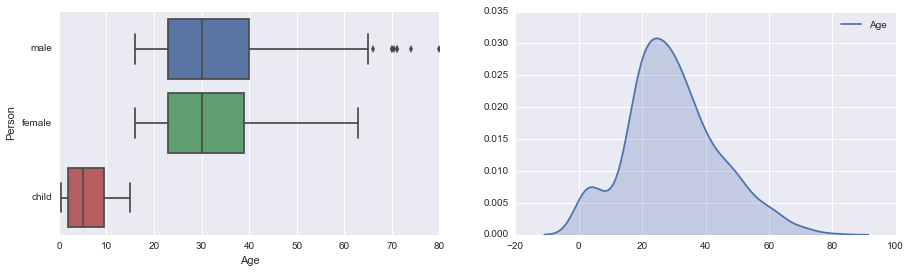

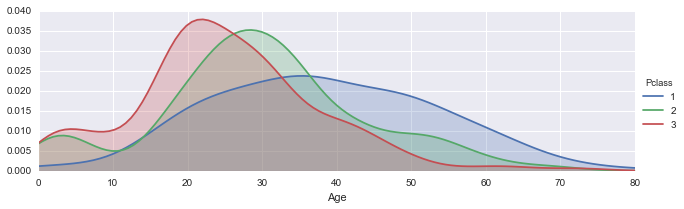

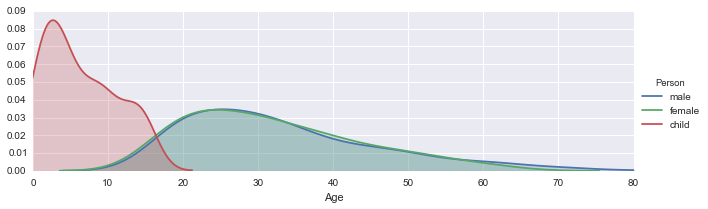

In [4]:
# Age Distribution --- explore/visualize the given data
gs1  = gs.GridSpec(1,2)
fig = plt.figure(figsize=(15,4)) 
ax1 = fig.add_subplot(gs1[0:1,0])
ax2 = fig.add_subplot(gs1[0:1,1])
sns.boxplot(df_train.Age, df_train.Person, ax=ax1)
sns.kdeplot(df_train.Age, shade=True, ax=ax2)

# Age by Class - continue with visualization 
f1 = sns.FacetGrid(df_train, hue='Pclass', hue_order=[1,2,3], aspect=3)
f1.map(sns.kdeplot, 'Age', shade=True)
f1.set(xlim=(0, df_train['Age'].max() ))
f1.add_legend()
# Age via Person
f2 = sns.FacetGrid(df_train, hue='Person', aspect=3)
f2.map(sns.kdeplot, 'Age', shade=True)
f2.set(xlim=(0, df_train['Age'].max() ))
f2.add_legend()

In [5]:
# Further Breakdown the Age vs Class Category
print "Pclass vs Age Statstics:"
summary = pd.DataFrame(df_train.pivot_table(values='Age', columns='Pclass', aggfunc=np.mean))
summary.rename(columns={'Age':'Mean'}, inplace=True)
summary["Median"] = df_train.pivot_table(values='Age', columns='Pclass', aggfunc=np.median) 
summary["STD"] = df_train.pivot_table(values='Age', columns='Pclass', aggfunc=np.std)
summary["Mode"] = df_train.pivot_table(values='Age', columns='Pclass', aggfunc=stats.mode) 
summary.columns.name = "Age"
summary

Pclass vs Age Statstics:


Age,Mean,Median,STD,Mode
Pclass,,,,
1,38.233441,37,14.802856,"([35.0], [9])"
2,29.877630,29,14.001077,"([24.0], [10])"
3,25.140620,24,12.495398,"([22.0], [20])"


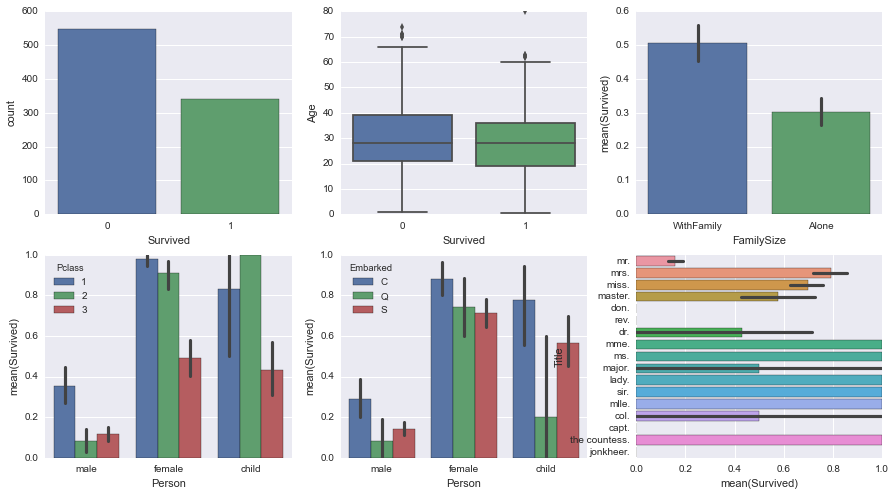

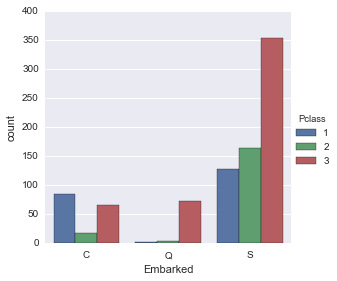

In [6]:
# Survival --- explore/visualize
gs2  = gs.GridSpec(2,3)
fig = plt.figure(figsize=(15,8)) 
ax1 = fig.add_subplot(gs2[0:1,0])
ax2 = fig.add_subplot(gs2[0:1,1])
ax3 = fig.add_subplot(gs2[0:1,2])
ax4 = fig.add_subplot(gs2[1:2,0])
ax5 = fig.add_subplot(gs2[1:2,1])
ax6 = fig.add_subplot(gs2[1:2,2])

sns.countplot(x='Survived', data=df_train, ax=ax1)
sns.boxplot(df_train.Survived, df_train.Age, ax=ax2)
sns.barplot(x='FamilySize', y='Survived', data=df_train, ax=ax3)
sns.barplot(x="Person", y="Survived", hue="Pclass", hue_order=[1,2,3], data=df_train, ax=ax4)
sns.barplot(x="Person", y="Survived", hue="Embarked", hue_order=['C','Q','S'], data=df_train, ax=ax5)
sns.barplot(y="Title", x="Survived", data=df_train, ax=ax6)
sns.factorplot(x="Embarked", hue='Pclass', order=['C','Q','S'], hue_order=[1,2,3], kind='count', data=df_train)

Deck Summary


,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U
distribution,15,47,59,33,33,13,7,1,687
survival,7,35,35,25,25,8,2,0,206


Occurences of Multiple Deck Distribution


,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U,Survived,FamilySize
75,0,0,0,0,0,1,1,0,0,0,Alone
128,0,0,0,0,1,1,0,0,0,1,WithFamily
699,0,0,0,0,0,1,1,0,0,0,Alone
715,0,0,0,0,0,1,1,0,0,0,Alone


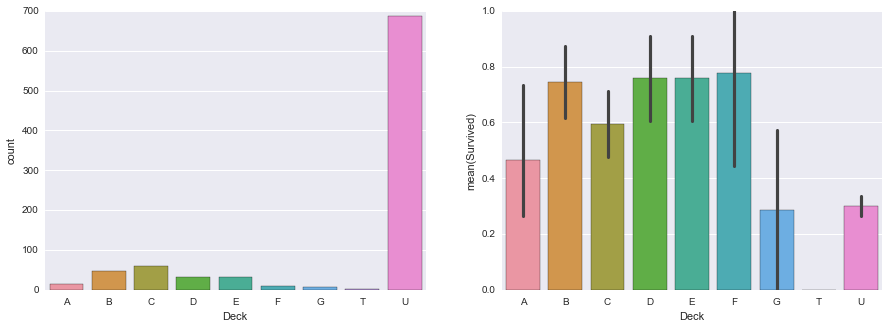

In [7]:
# Cabin Occurences (Cabin_U = Undefined, Cabin_T = N/A)
# Separate Attributes in case of circumstances of multiple different cabins per a particular observation
gs3  = gs.GridSpec(1,2)
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(gs3[0:1,0])
ax2 = fig.add_subplot(gs3[0:1,1])
deck_labels = [cab[1] for cab in [x.split("_") for x in list(df_train_decks.columns)] if len(cab)>1]
sns.countplot(x='Deck', data=df_train, order=deck_labels, ax=ax1)
sns.barplot(x='Deck', y='Survived', data=df_train, order=deck_labels, ax=ax2)
# Deck Summary
print "Deck Summary"
df_train_decksi = pd.concat([df_train, df_train_decks[train_deck_labels]],axis=1)
df_deck_summary = pd.DataFrame(df_train_decks[train_deck_labels].sum()).T
df_deck_summary = df_deck_summary.append(df_train_decksi[df_train_decksi.Survived==1][train_deck_labels].sum(), ignore_index=True)
df_deck_summary.index = ["distribution", "survival"]
display(df_deck_summary)
# Multiple Decks Allocation
print "Occurences of Multiple Deck Distribution"
df_train_decksi[df_train_decksi[train_deck_labels].sum(axis=1) > 1][train_deck_labels + ['Survived', 'FamilySize']]

Median Passenger Class Fare


Pclass
1    60.2875
2    14.2500
3     8.0500
Name: Fare, dtype: float64

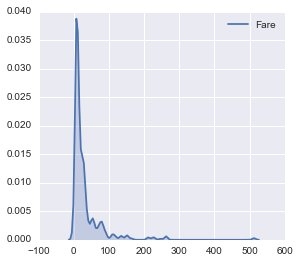

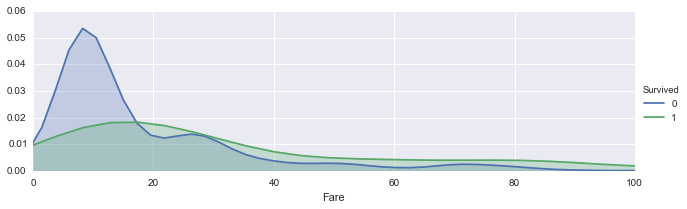

In [8]:
# Fare - explore/visualize
gs3  = gs.GridSpec(1,2)
fig = plt.figure(figsize=(15,9)) 
ax1 = fig.add_subplot(gs2[0:1,0])
sns.kdeplot(df_train.Fare, shade=True, ax=ax1)

f1 = sns.FacetGrid(df_train, hue='Survived', hue_order=[0,1], aspect=3)
f1.map(sns.kdeplot, 'Fare', shade=True)
f1.set(xlim=(df_train['Fare'].min(), 100 ))
f1.add_legend()

print "Median Passenger Class Fare"
df_train.pivot_table('Fare', columns = 'Pclass', aggfunc = 'median')

In [9]:
# per Titantic Encyclopedia (http://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html)
# mark as 'S', this just so happens to align with the 'mode' of embarked
print "Most Frequent Embarkment: ", df_train.Embarked.mode().values[0]
df_train[df_train.Embarked.isnull()]

Most Frequent Embarkment:  S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Person,Title,FamilySize,Deck
61,62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80,B28,NaN,female,miss.,Alone,B
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80,B28,NaN,female,mrs.,Alone,B


In [10]:
# feature correlation with Survived
# convert literal feature values to numerical feature values
df_train_mappednums = map_features(df_train)  
df_train_mappedcats = map_features_dummies(df_train)
# correlation of features with target ('Survived') before imputation
print "Numerical Mapping Correlation:"
display(pd.DataFrame(df_train_mappednums.corr().Survived).T)
print "Categorical Mapping Correlation:"
display(pd.DataFrame(df_train_mappedcats.corr().Survived).T)

Numerical Mapping Correlation:


/Users/akamlani/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:198: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Person,Title,FamilySize,Deck
Survived,-0.005007,1,-0.338481,-0.077221,-0.035322,0.081629,0.257307,-0.176509,-0.472637,-0.193635,0.203367,-0.302855


Categorical Mapping Correlation:


,Title_capt.,Title_col.,Title_don.,Title_dr.,Title_jonkheer.,Title_lady.,Title_major.,Title_master.,Title_miss.,Title_mlle.,Title_mme.,Title_mr.,Title_mrs.,Title_ms.,Title_rev.,Title_sir.,Title_the countess.,Person_child,Person_female,Person_male,FamilySize_Alone,FamilySize_WithFamily,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U,Embarked_C,Embarked_Q,Embarked_S,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,-0.026456,0.011329,-0.026456,0.008185,-0.026456,0.04247,0.011329,0.085221,0.327093,0.060095,0.04247,-0.549199,0.33904,0.04247,-0.064988,0.04247,0.04247,0.136107,0.506562,-0.55708,-0.203367,0.203367,0.022287,0.175095,0.114652,0.150716,0.150716,0.081827,-0.017955,-0.026456,-0.316912,0.16824,0.00365,-0.15566,-0.005007,1,-0.338481,-0.077221,-0.035322,0.081629,0.257307


#### Analysis of Feature Correlation w/Survived
* Numerical Mapping
    * Fare, FamilySize
* Categorical Mapping (Binary Dummies)
    * Females, Children, FamilySize > 1, Decks A/B, Embarkment 'C', Title Mrs./Miss., Fare
* Further correlation can be used such that features most correlated with one another are dropped

## More Feature Engineering (imputation)

In [11]:
# Further Feature Engineering - Preparation for input into model
# TBD: Patterns for Missing Data (Completely at Random, Random, Not Random)
def imputate_data(df):
    df_i = df.copy()
    # '0'/Missing values for Fare - calculate median of Fare per the class, rather than just median overall
    med_fare  = df_i.pivot_table('Fare', columns = 'Pclass', aggfunc = 'median')
    df_i.Fare = df_i[['Fare', 'Pclass']].apply(lambda x: med_fare[x['Pclass']] if (x['Fare']==0 or pd.isnull(x['Fare'])) else x['Fare'], axis=1)
    # Missing values for Age - calculate median
    avg_ages = df_i.pivot_table('Age', columns = 'Pclass', aggfunc = 'mean')
    med_ages = df_i.pivot_table('Age', columns = 'Pclass', aggfunc = 'median')
    df_i.Age = df_i[['Age', 'Pclass']].apply(lambda x: int(med_ages[x['Pclass']]) if pd.isnull(x['Age']) else x['Age'], axis =1)    
    # Missing Embarked Values - calculate mode ('S')
    df_i.Embarked = df_i.Embarked.fillna('S')
    # Missing Cabin Distribution - Marked as Deck_U
    #(Valid Values A-G, T=boat cabin, U=Unknown)
    
    # TBD: Feature Engineering for Ticket
    return df_i

df_train_fe = imputate_data(df_train)
df_train_fe.head()

/Users/akamlani/anaconda/lib/python2.7/site-packages/pandas/core/index.py:805: FutureWarning: scalar indexers for index type Int64Index should be integers and not floating point
  type(self).__name__),FutureWarning)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Person,Title,FamilySize,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,male,mr.,WithFamily,U
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,female,mrs.,WithFamily,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,female,miss.,Alone,U
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,female,mrs.,WithFamily,C
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,male,mr.,Alone,U


In [12]:
# re-execute feature engineering based on imputated data and subset data
df_train_mappednums = map_features(df_train_fe) 
df_train_mappednums = \
df_train_mappednums[['Person', 'Title', 'Age', 'Fare', 'FamilySize', 'Deck', 'Pclass', 'Embarked', 'Survived']]
df_train_mappedcats = map_features_dummies(df_train_fe)
df_train_mappedcats = \
df_train_mappedcats[['Title_mrs.', 'Title_ms.', 'Person_female', 'Person_child',
                     'FamilySize_WithFamily','Pclass', 'Age', 'Fare', 'Survived',
                     'Embarked_C','Embarked_Q','Embarked_S'] + train_deck_labels]

## PCA (Dimensionality Reduction)

In [13]:
def pca_modeling(X, y):
    # Minimum percentage of variance to be described by the resulting transformed components
    variance_pct = .95
    # Create PCA object
    pca = PCA(n_components=variance_pct)
    # Transform the initial features
    features_transformed = pca.fit_transform(X, y)
    # Create a data frame from the PCA'd data
    pca_df = pd.DataFrame(features_transformed)
    print pca_df.shape[1], " components describe ", str(variance_pct)[1:], "% of the variance"
    
pca_modeling(df_train_mappednums.drop(['Survived'], axis=1), df_train_mappednums['Survived'])
pca_modeling(df_train_mappedcats.drop(['Survived'], axis=1), df_train_mappedcats['Survived'])

2  components describe  .95 % of the variance
2  components describe  .95 % of the variance


## Logistic Regression Model

Cross-Validation Numeric Model: 0.769887640449
Cross-Validation Categorical Model: 0.82038701623


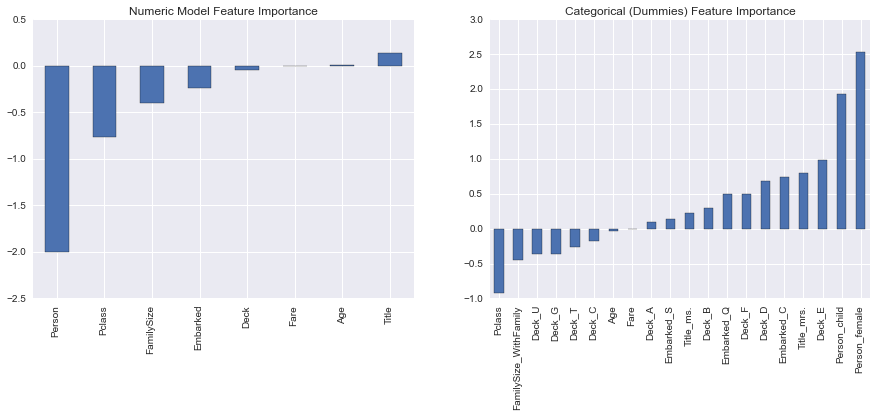

In [14]:
# determine the feature importance and cross-validation based on the two models
gs4  = gs.GridSpec(1,2)
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(gs4[0:1,0])
ax2 = fig.add_subplot(gs4[0:1,1])

# cross validation
def cross_validate(X, y, classifier, k_fold):
    # derive a set of (random) training and testing indices
    k_fold_indices = KFold(len(X), n_folds=k_fold,shuffle=True, random_state=0)
    k_score_total = 0
    # for each training and testing slices run the classifier, and score the results
    for train_slice, test_slice in k_fold_indices :
        model = classifier(X[ train_slice  ], y[ train_slice  ])
        k_score = model.score(X[ test_slice ],y[ test_slice ])
        k_score_total += k_score
    # return the average accuracy
    return k_score_total/k_fold

def plot_feature_importance(features, target, title_str, ax):
    #x = np.arange(len(features.columns))
    model_lr = LogisticRegression(C=1).fit(features, target)
    coefs = pd.Series(model_lr.coef_.ravel(), index = features.columns)
    coefs.sort()
    coefs.plot(kind="bar", ax=ax)
    ax.set_title(title_str)
    
features = df_train_mappednums.drop(['Survived'], axis=1)
target = df_train_mappednums['Survived']
plot_feature_importance(features, target, 'Numeric Model Feature Importance', ax1)    
cv = cross_validate(features.values, target.values, LogisticRegression(C=1).fit, 10)    
print "Cross-Validation Numeric Model: {0}".format(cv) 

features = df_train_mappedcats.drop(['Survived'], axis=1)
target = df_train_mappedcats['Survived']
plot_feature_importance(features, target, 'Categorical (Dummies) Feature Importance', ax2) 
cv = cross_validate(features.values, target.values, LogisticRegression(C=1).fit, 10)   
print "Cross-Validation Categorical Model: {0}".format(cv) 

# TBD: Further Analysis with normalizing the data (return (df - df.mean())/df.std())
# cv lower K = cheaper, less variance, more bias
# cv higher K = more expensive, more variance, and lower bias

#### Feature Importance + Cross-Validation Analysis
* The following Features seem do be most indicative with 'Survived': 
    * Title_mrs., Person_female, Person_child, Embarked_C, Deck_E
* We will move forward using the categorical (binary get_dummies) model, rather than a numeric, as the numeric is misleading, putting false importance on some categorical features.  It also has an improved cross-validation (cv) score.
* As noted with PCA, ideally the input features could be minimally transformed to 2 attributes.

In [15]:
# HyperParameter Tuning Checks
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
gsearch = grid_search.GridSearchCV(LogisticRegression(), param_grid)
gsearch.fit(features, target)
print "CV Score:", cross_validate(features.values, target.values, gsearch.best_estimator_.fit, 10) 
print gsearch.best_estimator_.get_params()

CV Score: 0.82038701623
{'C': 1, 'verbose': 0, 'intercept_scaling': 1, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l2', 'multi_class': 'ovr', 'random_state': None, 'dual': False, 'tol': 0.0001, 'solver': 'liblinear', 'class_weight': None}


In [16]:
# evaluate prediction (based on training model)
gsearch.best_estimator_.fit(features, target)
yhat = gsearch.best_estimator_.predict(features)
print "Prediction Evaluation Score:", metrics.precision_score(target, yhat) 

Prediction Evaluation Score: 0.793846153846


In [17]:
# probability estimates (returns [n_samples, n_classes])
# Look at P(y=1) (target_predicted_proba[:,1])
target_predicted_proba = gsearch.best_estimator_.predict_proba(features)
proba = pd.DataFrame(target_predicted_proba[:,1])
proba['class_probability'] = proba[0].apply(lambda x:0 if x<.5 else 1)
metrics.precision_score(target, proba['class_probability']) 

0.79384615384615387

Eval based on Test Split from Training data: MSE=0.178770949721, RMSE=0.422813138065
Eval Accuracy Score=0.821229050279, AUC=0.878764478764
Classification Report:
             precision    recall  f1-score   support

    class 0       0.85      0.85      0.85       105
    class 1       0.78      0.78      0.78        74

avg / total       0.82      0.82      0.82       179



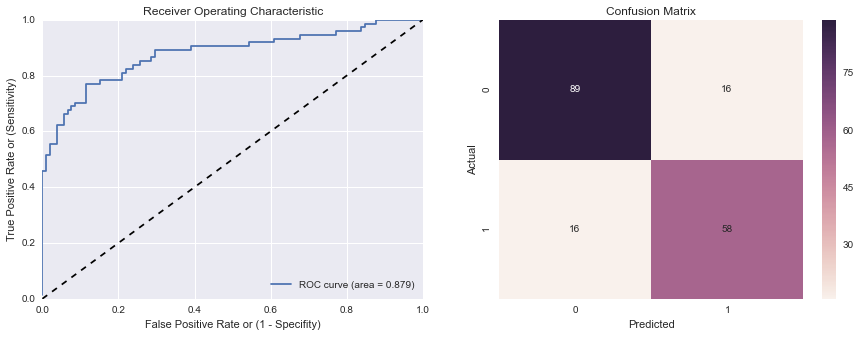

In [18]:
# ROC, AUC w/split based on training/test split model data
gs5  = gs.GridSpec(1,2)
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(gs5[0:1,0])
ax2 = fig.add_subplot(gs5[0:1,1])

def plot_roc_curve(target_test, target_predicted_proba, ax):
    fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    ax.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('False Positive Rate or (1 - Specifity)')
    ax.set_ylabel('True Positive Rate or (Sensitivity)')
    ax.set_title('Receiver Operating Characteristic')
    ax.legend(loc="lower right")
    return fpr, tpr, thresholds

# using classic 80/20 split model  
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.8)
gsearch.best_estimator_.fit(X_train, y_train)
yhat = gsearch.best_estimator_.predict(X_test)
target_predicted_proba = gsearch.best_estimator_.predict_proba(X_test)
fpr, tpr, thresholds = plot_roc_curve(y_test, target_predicted_proba, ax1)
MSE = eval_measures.mse(yhat, y_test, axis=0)    
RMSE = eval_measures.rmse(yhat, y_test, axis=0)
print "Eval based on Test Split from Training data: MSE={0}, RMSE={1}".format(MSE,RMSE)
accuracy_score = metrics.accuracy_score(y_test, yhat)
auc_score = metrics.roc_auc_score(y_test, target_predicted_proba[:, 1])
print "Eval Accuracy Score={0}, AUC={1}".format(accuracy_score, auc_score)

#Confusion Matrix = {TPR, FPR, FNR, TNR}
#pd.crosstab(y_test, yhat, rownames=['Actual'], colnames=['Predicted'])
print "Classification Report:\n",(metrics.classification_report(y_test, yhat, target_names=['class 0', 'class 1']))
cm = metrics.confusion_matrix(y_test, yhat)
sns.heatmap(cm, annot=True, fmt="d", ax=ax2)
ax2.set_ylabel("Actual")
ax2.set_xlabel("Predicted")
ax2.set_title("Confusion Matrix")

In [19]:
# Use model to evaulate given test data
df_test_fe = imputate_data(df_test)
df_test_mappedcats = map_features_dummies(df_test_fe)
features = \
df_test_mappedcats[['Title_mrs.', 'Title_ms.', 'Person_female', 'Person_child',
                    'FamilySize_WithFamily','Pclass', 'Age', 'Fare',
                    'Embarked_C','Embarked_Q','Embarked_S'] + test_deck_labels]
diff_cols = list(set(train_deck_labels) - set(test_deck_labels))[0]
features.is_copy = False
features.loc[:, diff_cols] = 0
# Model Analysis on feature engineered test data
yhat = gsearch.best_estimator_.predict(features.values)
results = pd.DataFrame(df_test_mappedcats['PassengerId'])
results['Survived'] = yhat
results.to_csv('titanic_results.csv', sep = ',', index = None)

In [20]:
# TBD: Review Thresholds
# Modify Threshold from 0.50 to 0.58
target_predicted_proba = gsearch.best_estimator_.predict_proba(features)
proba = pd.DataFrame(target_predicted_proba[:,1])
proba['class_0_at_58'] = proba[0].apply(lambda x:0 if x<.58 else 1)
results = pd.DataFrame(df_test_mappedcats['PassengerId'])
results['Survived'] = proba['class_0_at_58']
results.to_csv('titanic_results_with_threshold.csv', sep = ',', index = None)